In [1]:
from sea_breeze import load_model_data, utils
import xarray as xr
from dask.distributed import Client
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import logging
import datetime as dt
import pandas as pd

logging.getLogger("flox").setLevel(logging.WARNING)

In [2]:
def preprocess(ds):
    ds["time"] = pd.to_datetime(ds.time) + dt.timedelta(hours=11)
    #return ds["mask"].resample({"time":"1D"}).max()
    return ds["mask"].groupby(ds.time.dt.date).max()

def load(model,diagnostic,chunks={"time":10}):

    ds = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+\
                      model+\
                      "/filters/filtered_mask_no_hourly_change_"+\
                      diagnostic+\
                      "_*.zarr/",
                 chunks=chunks, engine="zarr",preprocess=preprocess)   
    
    return ds

def load_hourly(model,diagnostic,chunks={"time":10}):

    ds = xr.open_mfdataset("/g/data/ng72/ab4502/sea_breeze_detection/"+\
                      model+\
                      "/filters/filtered_mask_no_hourly_change_"+\
                      diagnostic+\
                      "_*.zarr/",
                 chunks=chunks, engine="zarr")   
    ds["time"] = pd.to_datetime(ds.time) + dt.timedelta(hours=11)
    
    return ds

def count_num_of_objs(da):
    x = np.unique(da)
    x = x[x!=0]
    x = x[~np.isnan(x)]
    return len(x)

def mask(ds,angle_ds,mask=True,mask_thresh=0.5):
    return xr.where(angle_ds.variance_interp<mask_thresh, ds, np.nan)    

In [3]:
Client()

2025-04-29 10:13:07,242 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2025-04-29 10:13:07,245 - distributed.utils - INFO - Reload module schedplugin from .py file
2025-04-29 10:13:07,276 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-cpu-bdw-0048.gadi.nci.org.au/63697/proxy/8787/status,
Dashboard: /node/gadi-cpu-bdw-0048.gadi.nci.org.au/63697/proxy/8787/status,Workers: 14
Total threads: 14,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46403,Workers: 14
Dashboard: /node/gadi-cpu-bdw-0048.gadi.nci.org.au/63697/proxy/8787/status,Total threads: 14
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:44357,Total threads: 1
Dashboard: /node/gadi-cpu-bdw-0048.gadi.nci.org.au/63697/proxy/42393/status,Memory: 0 B
Nanny: tcp://127.0.0.1:39699,


2025-04-29 10:14:03,031 - tornado.application - ERROR - Uncaught exception GET /individual-progress/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='gadi-cpu-bdw-0048.gadi.nci.org.au:63697', method='GET', uri='/individual-progress/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/web.py", line 1790, in _execute
    result = await result
             ^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/websocket.py", line 273, in get
    await self.ws_connection.accept_connection(self)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/websocket.py", line 863, in accept_connection
    await self._accept_connection(handler)
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.04/lib/python3.11/site-packages/tornado/websocket.py", li

In [4]:
m="barra_c"
angle_ds = load_model_data.get_coastline_angle_kernel(
    compute=False,
    path_to_load="/g/data/ng72/ab4502/coastline_data/"+m+".nc",
    lat_slice=slice(-45.7,-6.9),
    lon_slice=slice(108,158.5)
)

orog, lsm = load_model_data.load_barra_static("AUST-04",slice(108,158.5),slice(-45.7,-6.9))

In [5]:
m = "barra_c_smooth_s2"
c = {"time":100}

#F = load(m,"F",chunks=c)
F_hourly = load_hourly(m,"F",chunks=c)
F = F_hourly.groupby(F_hourly.time.dt.date).max()

In [6]:
F_sum = (F.mask.sum("date") / F.mask.date.shape[0]).persist()

In [7]:
F_hourly_sum = F_hourly.mask.sum("time").persist()

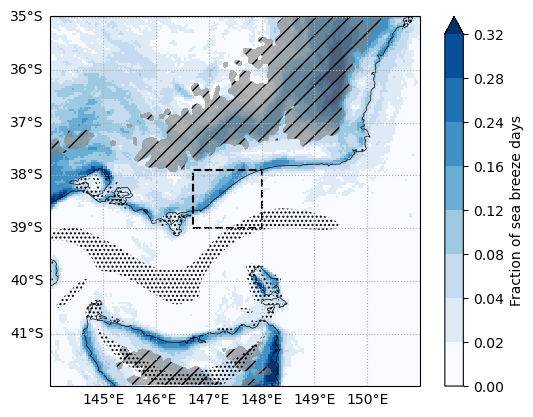

In [12]:
def draw_boxes(lon_slice,lat_slice):

    plt.plot([lon_slice.start,lon_slice.stop,lon_slice.stop,lon_slice.start,lon_slice.start],
             [lat_slice.start,lat_slice.start,lat_slice.stop,lat_slice.stop,lat_slice.start],
             color="k",ls="--")    

lat_slice = slice(-42,-35)
lon_slice = slice(144,151)

zoom_box_lat = slice(-39,-37.9)
zoom_box_lon = slice(146.7,148)
p_lat = -38
p_lon = 147.5

#levels = np.linspace(0,0.4,6)
levels = [0,0.04,0.08,0.12,0.16,0.02,0.24,0.28,0.32]

ax=plt.axes(projection=ccrs.PlateCarree())
F_sum.sel(lat=lat_slice,lon=lon_slice).plot(cmap="Blues",levels=levels,cbar_kwargs={"label":"Fraction of sea breeze days"})
xr.plot.contourf(orog.sel(lat=lat_slice,lon=lon_slice),levels=[500,10000],extend="neither",colors=["grey"],alpha=0.6,hatches=["//"],add_colorbar=False)
xr.plot.contourf(angle_ds.variance_interp.sel(lat=lat_slice,lon=lon_slice),levels=[0.5,1],extend="neither",colors=["none"],alpha=0,hatches=["...."],add_colorbar=False)
ax.coastlines(lw=0.5)
draw_boxes(zoom_box_lon,zoom_box_lat)
#plt.plot(p_lon,p_lat,marker="x",color="k")
ax.gridlines(draw_labels=["left","bottom"],ls=":")

In [26]:
uas = []
vas = []
tas = []
hus = []
times = [("2013-01-01 00:00","2013-02-28 23:00"),
         ("2016-01-01 00:00","2016-02-29 23:00"),
         ("2018-01-01 00:00","2018-02-28 23:00")]
for t in times:

    vas.append(load_model_data.load_barra_variable(
                "vas",
                t[0],
                t[1],
                "AUST-04",
                "1hr",
                lat_slice,
                lon_slice,
                chunks={}))
    
    uas.append(load_model_data.load_barra_variable(
                "uas",
                t[0],
                t[1],
                "AUST-04",
                "1hr",
                lat_slice,
                lon_slice,
                chunks={}))

    tas.append(load_model_data.load_barra_variable(
                "tas",
                t[0],
                t[1],
                "AUST-04",
                "1hr",
                lat_slice,
                lon_slice,
                chunks={}))

    hus.append(load_model_data.load_barra_variable(
                "huss",
                t[0],
                t[1],
                "AUST-04",
                "1hr",
                lat_slice,
                lon_slice,
                chunks={}))    

uas = xr.concat(uas,"time")
vas = xr.concat(vas,"time")


In [27]:
tas = xr.concat(tas,"time")
hus = xr.concat(hus,"time")

In [28]:
ws = np.sqrt( uas**2 + vas**2 )

In [32]:
uas["time"] = pd.to_datetime(uas.time) + dt.timedelta(hours=11)
vas["time"] = pd.to_datetime(vas.time) + dt.timedelta(hours=11)
tas["time"] = pd.to_datetime(tas.time) + dt.timedelta(hours=11)
hus["time"] = pd.to_datetime(hus.time) + dt.timedelta(hours=11)
ws["time"] = pd.to_datetime(ws.time) + dt.timedelta(hours=11)

In [13]:
# #Define sea breeze days as when there is a sea breeze object anywhere in the zoom box

sb_ts = F.mask.sel(lat=zoom_box_lat,lon=zoom_box_lon).max(("lat","lon")).values

#Number of days with a SB somewhere in the box
print(sb_ts.sum())

105


In [16]:
print((~sb_ts).sum())

76


In [22]:
#Frequency of SB days anywhere in box
105 / F.mask.shape[0]

0.580110497237569

In [23]:
#Largest SB freq at any given point
F_sum.sel(lat=zoom_box_lat,lon=zoom_box_lon).max(("lat","lon")).values

array(0.26519337)

In [37]:
#Get the hourly times for the sea breeze dates

sb_hourly_times = (np.in1d(uas.time.dt.date,F.date[sb_ts]))
nonsb_hourly_times = np.in1d(uas.time.dt.date,F.date[~sb_ts])

In [38]:
#Slice the u and v wind to hourly times on sb days and non sb days. Group by hour and average

vas_sb_comp = vas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
uas_sb_comp = uas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
hus_sb_comp = hus.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()
tas_sb_comp = tas.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()

vas_nonsb_comp = vas.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
uas_nonsb_comp = uas.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
hus_nonsb_comp = hus.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()
tas_nonsb_comp = tas.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()



In [39]:
ws_sb_comp = ws.sel(time=sb_hourly_times).groupby("time.hour").mean().persist()

ws_nonsb_comp = ws.sel(time=nonsb_hourly_times).groupby("time.hour").mean().persist()

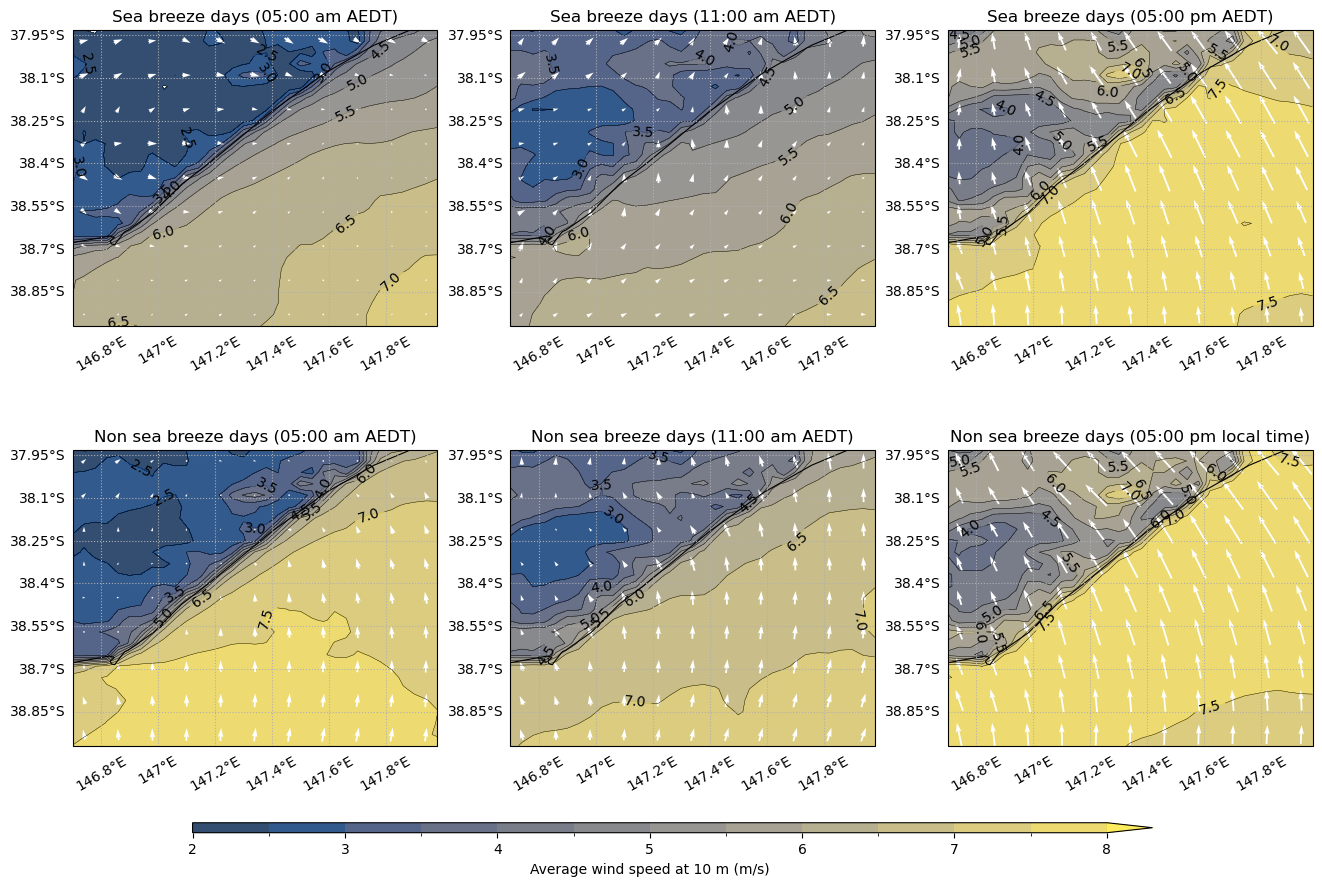

In [65]:
def plot_comp(ax,ds_u,ds_v,h,c,orog,ds_field=None,field_cmap="Blues",field_vmin=None,field_vmax=None,l=10,title=""):

    #ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
    if ds_field is not None:
        fc=xr.plot.contourf(ds_field.sel(hour=h),cmap=field_cmap,vmin=field_vmin,vmax=field_vmax,levels=l,extend="max",add_colorbar=False,alpha=0.8)
        cs=xr.plot.contour(ds_field.sel(hour=h),vmin=field_vmin,vmax=field_vmax,levels=l,colors="k",linewidths=0.3)
        plt.clabel(cs)
        
    #xr.plot.contourf(orog,levels=[500,10000],extend="neither",colors=["grey"],alpha=0.6,add_colorbar=False)

    xr.Dataset({"u":ds_u,"v":ds_v}).sel(hour=h).coarsen({"lat":c,"lon":c},boundary="pad").mean().plot.quiver(
        x="lon",y="lat",u="u",v="v",scale=50,color="white",width=0.005,add_guide=False)
    
    ax.coastlines(lw=0.8)
    #draw_boxes(zoom_box_lon,zoom_box_lat)
    #plt.plot(p_lon,p_lat,marker="x",color="k")
    ax.gridlines(xlabel_style={"rotation":30},draw_labels=["left","bottom"],ls=":")    

    plt.title(title)

    if ds_field is not None:
        return fc


plt.figure(figsize=[16,10])

vmin=2
vmax=8
l=13
cmap="cividis"

ax=plt.subplot(2,3,1,projection=ccrs.PlateCarree())
fc=plot_comp(
    ax,
    uas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    5,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    ws_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Sea breeze days (05:00 am AEDT)")

ax=plt.subplot(2,3,4,projection=ccrs.PlateCarree())
fc=plot_comp(
    ax,
    uas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    5,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    ws_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Non sea breeze days (05:00 am AEDT)")

ax=plt.subplot(2,3,2,projection=ccrs.PlateCarree())
plot_comp(
    ax,
    uas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    11,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    ws_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Sea breeze days (11:00 am AEDT)")    

ax=plt.subplot(2,3,5,projection=ccrs.PlateCarree())
plot_comp(
    ax,
    uas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    11,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    ws_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Non sea breeze days (11:00 am AEDT)")    

ax=plt.subplot(2,3,3,projection=ccrs.PlateCarree())
plot_comp(
    ax,
    uas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    17,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    ws_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Sea breeze days (05:00 pm AEDT)")        

ax=plt.subplot(2,3,6,projection=ccrs.PlateCarree())
plot_comp(
    ax,
    uas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    17,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    ws_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Non sea breeze days (05:00 pm local time)")        


cb=plt.colorbar(fc,cax=plt.axes([0.2,0.05,0.6,0.01]),orientation="horizontal")
cb.set_label("Average wind speed at 10 m (m/s)")
#plt.subplots_adjust(hspace=0.3)

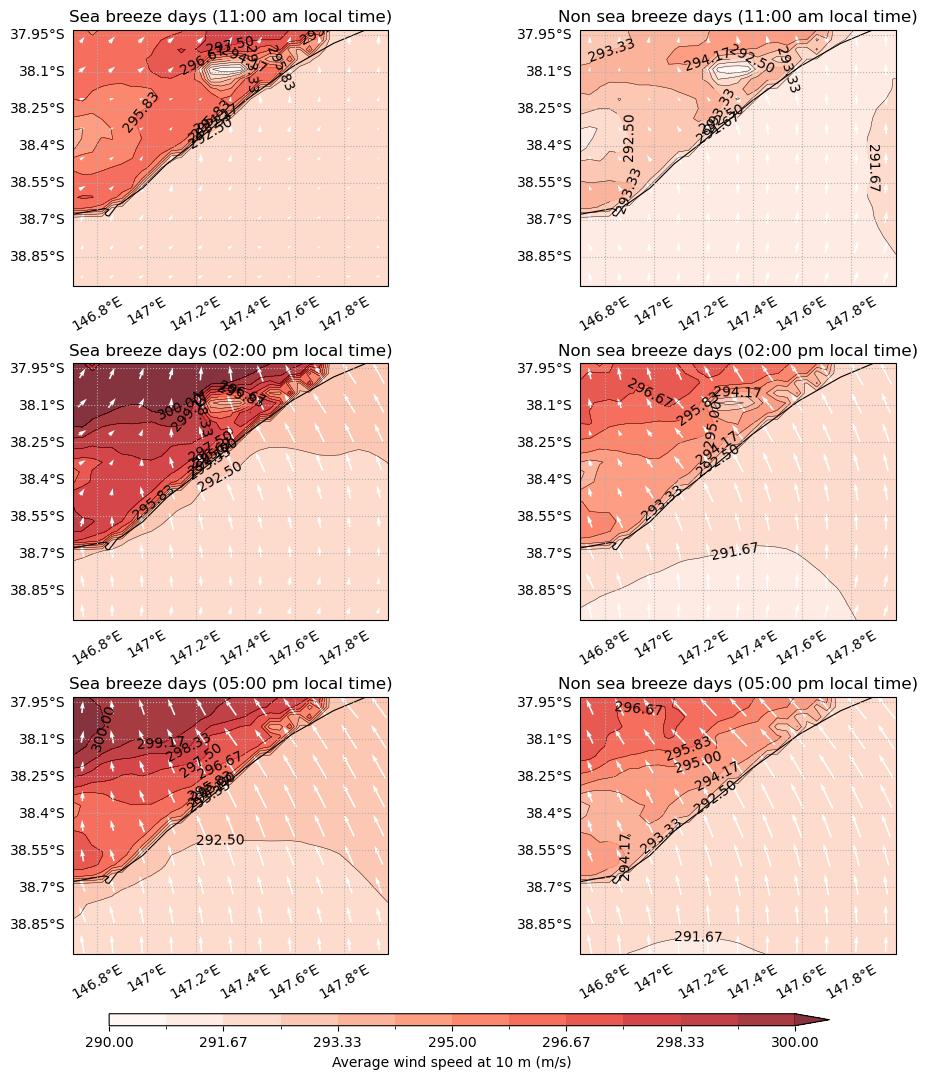

In [46]:
plt.figure(figsize=[12,12])

vmin=290
vmax=300
l=13
cmap="Reds"

ax=plt.subplot(3,2,1,projection=ccrs.PlateCarree())
fc=plot_comp(
    ax,
    uas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    11,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    tas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Sea breeze days (11:00 am local time)")

ax=plt.subplot(3,2,2,projection=ccrs.PlateCarree())
fc=plot_comp(
    ax,
    uas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    11,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    tas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Non sea breeze days (11:00 am local time)")

ax=plt.subplot(3,2,3,projection=ccrs.PlateCarree())
plot_comp(
    ax,
    uas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    14,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    tas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Sea breeze days (02:00 pm local time)")    

ax=plt.subplot(3,2,4,projection=ccrs.PlateCarree())
plot_comp(
    ax,
    uas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    14,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    tas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Non sea breeze days (02:00 pm local time)")    

ax=plt.subplot(3,2,5,projection=ccrs.PlateCarree())
plot_comp(
    ax,
    uas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    17,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    tas_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Sea breeze days (05:00 pm local time)")        

ax=plt.subplot(3,2,6,projection=ccrs.PlateCarree())
plot_comp(
    ax,
    uas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    vas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    17,
    3,
    orog.sel(lat=lat_slice,lon=lon_slice),
    tas_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
    l=l,
    field_vmin=vmin,
    field_vmax=vmax,
    field_cmap=cmap,
    title="Non sea breeze days (05:00 pm local time)")        


cb=plt.colorbar(fc,cax=plt.axes([0.2,0.05,0.6,0.01]),orientation="horizontal")
cb.set_label("Average wind speed at 10 m (m/s)")
plt.subplots_adjust(hspace=0.3)

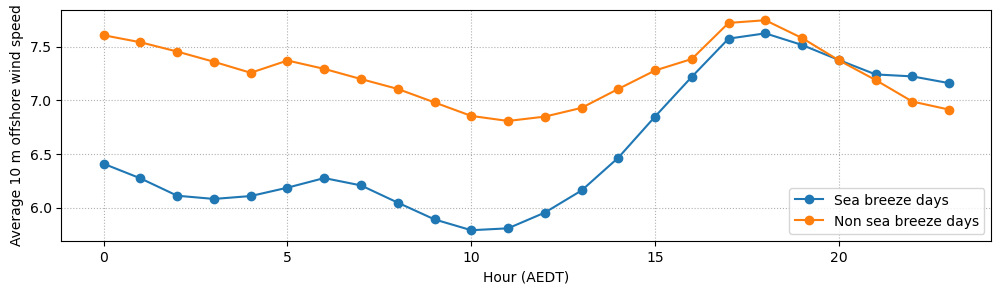

In [58]:
plt.figure(figsize=[12,3])

xr.where(lsm.sel(lat=zoom_box_lat,lon=zoom_box_lon)==0,
ws_sb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
     np.nan).mean(("lat","lon")).plot(marker="o",label="Sea breeze days")

xr.where(lsm.sel(lat=zoom_box_lat,lon=zoom_box_lon)==0,
ws_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon),
     np.nan).mean(("lat","lon")).plot(marker="o",label="Non sea breeze days")

plt.legend()
plt.title("")
plt.ylabel("Average 10 m offshore wind speed")
plt.xlabel("Hour (AEDT)")
plt.gca().grid(ls=":")
# print(
#     xr.where(lsm.sel(lat=zoom_box_lat,lon=zoom_box_lon)==0,
#     ws_nonsb_comp.sel(lat=zoom_box_lat,lon=zoom_box_lon).sel(hour=[11,14,17]),
#          np.nan).mean(("lat","lon")).values
# )

Text(0.5, 1.0, 'Non-SB days')

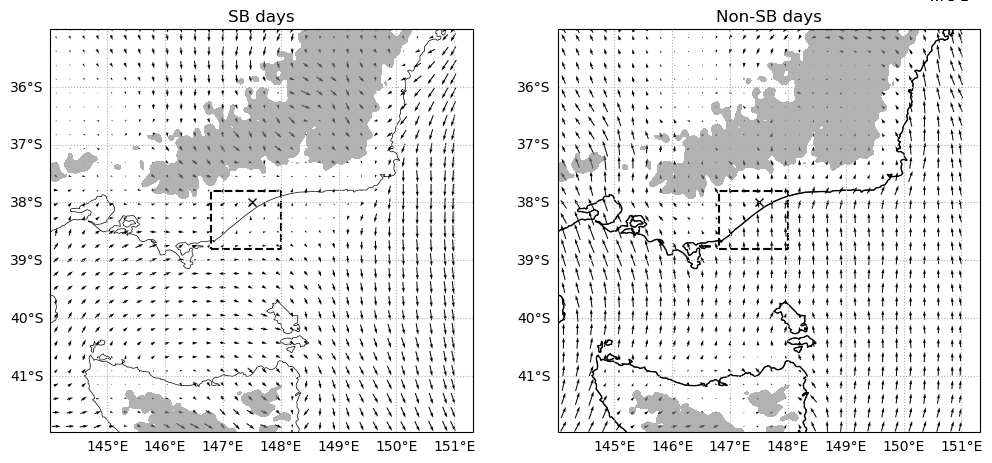

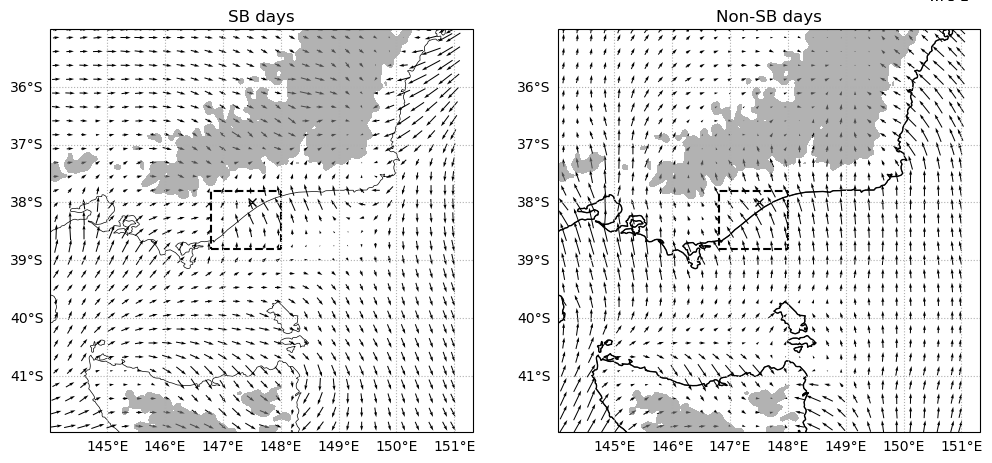

In [168]:
plt.figure(figsize=[12,6])

h=0

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
xr.Dataset({"u":uas_sb_comp,"v":vas_sb_comp}).sel(hour=h).coarsen({"lat":6,"lon":6},boundary="pad").mean().plot.quiver(
    x="lon",y="lat",u="u",v="v",scale=100)

xr.plot.contourf(orog.sel(lat=lat_slice,lon=lon_slice),levels=[500,10000],extend="neither",colors=["grey"],alpha=0.6,add_colorbar=False)
ax.coastlines(lw=0.5)
draw_boxes(zoom_box_lon,zoom_box_lat)
plt.plot(p_lon,p_lat,marker="x",color="k")
ax.gridlines(draw_labels=["left","bottom"],ls=":")


plt.title("SB days")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
xr.Dataset({"u":uas_nonsb_comp,"v":vas_nonsb_comp}).sel(hour=h).coarsen({"lat":6,"lon":6},boundary="pad").mean().plot.quiver(
    x="lon",y="lat",u="u",v="v",scale=100)
ax.coastlines()

xr.plot.contourf(orog.sel(lat=lat_slice,lon=lon_slice),levels=[500,10000],extend="neither",colors=["grey"],alpha=0.6,add_colorbar=False)
ax.coastlines(lw=0.5)
draw_boxes(zoom_box_lon,zoom_box_lat)
plt.plot(p_lon,p_lat,marker="x",color="k")
ax.gridlines(draw_labels=["left","bottom"],ls=":")

plt.title("Non-SB days")




plt.figure(figsize=[12,6])

h=3

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
xr.Dataset({"u":uas_sb_comp,"v":vas_sb_comp}).sel(hour=h).coarsen({"lat":6,"lon":6},boundary="pad").mean().plot.quiver(
    x="lon",y="lat",u="u",v="v",scale=100)

xr.plot.contourf(orog.sel(lat=lat_slice,lon=lon_slice),levels=[500,10000],extend="neither",colors=["grey"],alpha=0.6,add_colorbar=False)
ax.coastlines(lw=0.5)
draw_boxes(zoom_box_lon,zoom_box_lat)
plt.plot(p_lon,p_lat,marker="x",color="k")
ax.gridlines(draw_labels=["left","bottom"],ls=":")


plt.title("SB days")

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
xr.Dataset({"u":uas_nonsb_comp,"v":vas_nonsb_comp}).sel(hour=h).coarsen({"lat":6,"lon":6},boundary="pad").mean().plot.quiver(
    x="lon",y="lat",u="u",v="v",scale=100)
ax.coastlines()

xr.plot.contourf(orog.sel(lat=lat_slice,lon=lon_slice),levels=[500,10000],extend="neither",colors=["grey"],alpha=0.6,add_colorbar=False)
ax.coastlines(lw=0.5)
draw_boxes(zoom_box_lon,zoom_box_lat)
plt.plot(p_lon,p_lat,marker="x",color="k")
ax.gridlines(draw_labels=["left","bottom"],ls=":")

plt.title("Non-SB days")

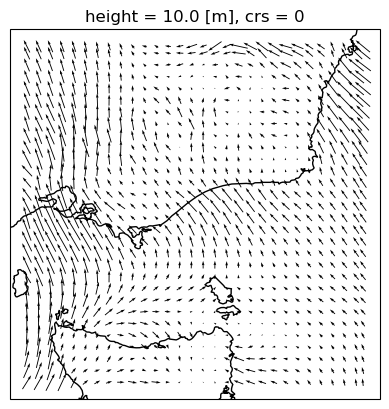

In [157]:
F_sb_comp = F_hourly.sel(lat=lat_slice,lon=lon_slice).mask.sel(time=sb_comp_times).sum("time").persist()
F_nonsb_comp = F_hourly.sel(lat=lat_slice,lon=lon_slice).mask.sel(time=nonsb_comp_times).sum("time").persist()

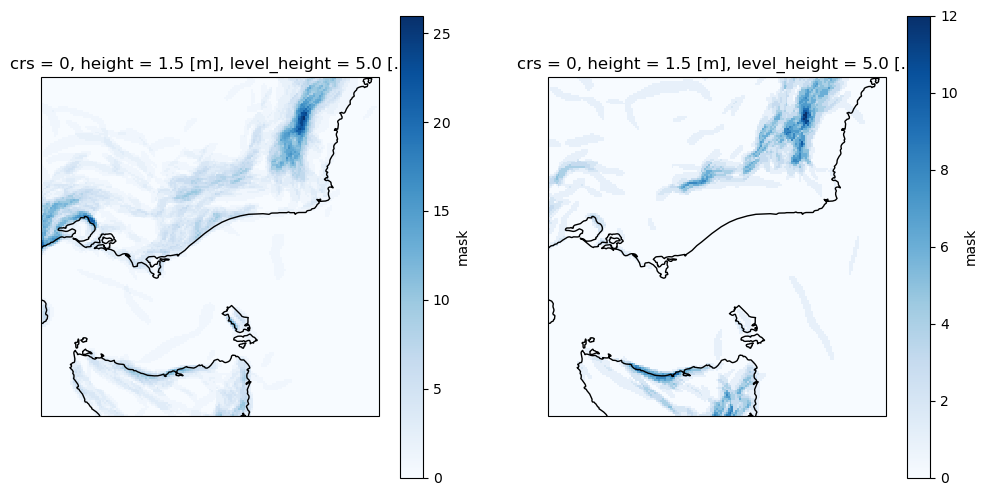

In [160]:
plt.figure(figsize=[12,6])

ax=plt.subplot(1,2,1,projection=ccrs.PlateCarree())
F_sb_comp.plot(cmap="Blues")
ax.coastlines()

ax=plt.subplot(1,2,2,projection=ccrs.PlateCarree())
F_nonsb_comp.plot(cmap="Blues")
ax.coastlines()

In [161]:
uas

<xarray.DataArray 'uas' (time: 4272, lat: 175, lon: 175)> Size: 1GB
dask.array<concatenate, shape=(4272, 175, 175), dtype=float64, chunksize=(12, 123, 108), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 34kB 2013-01-01 ... 2018-02-28T23:00:00
    height   float64 8B 10.0
  * lon      (lon) float64 1kB 144.0 144.1 144.1 144.1 ... 150.9 150.9 151.0
  * lat      (lat) float64 1kB -41.97 -41.93 -41.89 ... -35.09 -35.05 -35.01
    crs      int32 4B 0
Attributes:
    long_name:      Eastward Near-Surface Wind
    standard_name:  eastward_wind
    units:          m s-1
    cell_methods:   time: point (interval: 1H) area: interpolation (method: b...
    grid_mapping:   crs
    smoothed:       False